## TMDB Netflix Movie Recommendation System using Clustering 
# Introduction

Have you ever watched a movie and wished you had a smart friend who could instantly recommend similar films you'd love next? 
-That’s exactly what this project sets out to do.

-In this project, we built a movie recommendation system using clustering techniques. Instead of relying on complex user ratings or collaborative filters, we used the features of the movies themselves — like their genre, popularity, and average user ratings (vote_average) — to group similar films together. 

-This way, when a user inputs a movie title, we can suggest other movies from the same cluster that are likely to match their taste.

-By applying unsupervised learning (KMeans clustering) on carefully selected features, we created a system that recommends movies in a way that feels intuitive and personalized — even without prior user history.

## Technologies Used
Python :	Core programming language for building the entire pipeline
Pandas :	Data cleaning, merging, and manipulation
NumPy  :	Numerical operations and array handling
Matplotlib & Seaborn :	Data visualization and plotting elbow/silhouette curves
Scikit-learn :	Clustering (KMeans), feature scaling, and evaluation (silhouette score)
Jupyter Notebook / Kaggle: 	Interactive development and visualization environment

## Data Descriptions 

### We used and merged two datasets that contain rich metadata about movies:

1. movies_metadata.csv

2. credits.csv 

These datasets include details like genres, popularity, ratings, and more — essential for building our recommender.


### Here are some key features in our merged dataset:

1. budget – The estimated budget for the movie (in USD).
2. genres – A list of genres associated with the movie (e.g., Action, Drama).
3. homepage – The official website of the movie, if available.
4. id – Unique identifier for each movie.
5. keywords – Important keywords or tags related to the movie’s plot.
6. original_language – The original language the movie was filmed in.
7. original_title – The title of the movie before translation or localization.
8. overview – A short description or summary of the movie’s storyline.
9. popularity – A numeric score indicating how popular the movie is.
10. production_companies – List of production companies involved.
11. production_countries – Countries involved in the production.
12. release_date – Official release date of the movie.
13. revenue – Total box office earnings of the movie (in USD).
14. runtime – Duration of the movie in minutes.
15. spoken_languages – List of languages spoken in the movie.
16. status – Current status of the movie (e.g., Released, Post Production).
17. tagline – A catchy phrase or slogan used to market the movie.
18. title_x – Movie title from the first dataset.
19. vote_average – Average rating the movie received from viewers.
20. vote_count – Number of user ratings/votes the movie has received.
21. title_y – Movie title from the second dataset (e.g., for consistency after merge).
22. cast – List of actors in the movie (from the credits dataset).
23. crew – List of key crew members like directors and producers.

✅ These features helped us in cleaning, feature selection, and building the recommendation logic.

In [5]:
# Install the necessary pakages and libraries
! pip install Pandas
! pip install numpy
! pip install scikit-learn
! pip install matplotlib
! pip install seaborn 

In [6]:
#Importing Necessary Libraries 
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

## STEP 1 : Data Loading and & Merging 
### Here we use two movie-related datasets and merged them to create a single, unified dataframe containing detailed information about each film — including genres, vote averages, popularity, and more.

In [7]:
#loading the file from pandas

import pandas as pd

# Load the datasets
movies_df = pd.read_csv('tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb_5000_credits.csv')

# Rename 'movie_id' in credits_df to match the 'id' in movies_df
credits_df.rename(columns={'movie_id': 'id'}, inplace=True)

# Merge on 'id'
merged_df = movies_df.merge(credits_df, on='id')

# Save to a new CSV if needed
merged_df.to_csv('tmdb_merged.csv', index=False)

# View the new columns
print(merged_df.columns)


Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')


In [8]:
#Cleaning the columns , and renaming the titles (x & y) as title
final_df = merged_df[[
    'title_x', 'genres', 'vote_average', 'popularity', 'cast', 'crew'
]].rename(columns={'title_x': 'title'})

## Have a look at the final data frame

In [ ]:
#We need title , genere, vote_average , popularity for this project , it also shows cast ,crew and more.
final_df

,title,genres,vote_average,popularity,cast,crew,genre_list,cluster
0,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",7.2,150.437577,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...","[Action, Adventure, Fantasy, Science Fiction]",2
1,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",6.9,139.082615,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...","[Adventure, Fantasy, Action]",2
2,Spectre,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.3,107.376788,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...","[Action, Adventure, Crime]",3
3,The Dark Knight Rises,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",7.6,112.312950,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...","[Action, Crime, Drama, Thriller]",8
4,John Carter,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.1,43.926995,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...","[Action, Adventure, Science Fiction]",3
...,...,...,...,...,...,...,...,...
4798,El Mariachi,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",6.6,14.269792,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de...","[Action, Crime, Thriller]",5
4799,Newlyweds,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",5.9,0.642552,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de...","[Comedy, Romance]",0
4800,"Signed, Sealed, Delivered","[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",7.0,1.444476,"[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de...","[Comedy, Drama, Romance, TV Movie]",0
4801,Shanghai Calling,[],5.7,0.857008,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de...",[],9


In [10]:
#Drop rows of missing values in the important columns 
final_df = final_df.dropna(subset=['genres','vote_average','popularity'])

In [11]:
#Extract genre names from JSON-like string
def parse_genres(genre_str):
    """Converts a string of genre dictionaries into a list of genre names."""
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

# Apply the parsing function to each row
final_df['genre_list'] = final_df['genres'].apply(parse_genres)




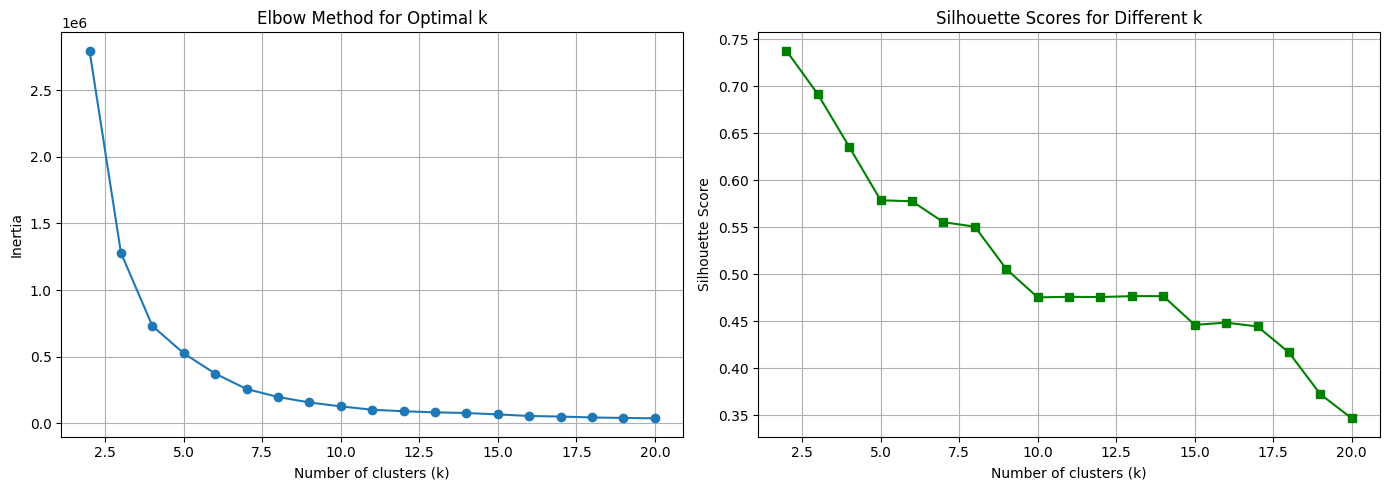

In [12]:
# Binarize genre_list
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(final_df['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# Combine features
final_features = pd.concat([
    genre_df.reset_index(drop=True),
    final_df[['vote_average', 'popularity']].reset_index(drop=True)
], axis=1)

inertia_values = []
silhouette_scores = []
k_values = range(2, 21)

for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(final_features)
    inertia_values.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(final_features, kmeans_model.labels_))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(k_values, inertia_values, marker='o')
axs[0].set_title('Elbow Method for Optimal k')
axs[0].set_xlabel('Number of clusters (k)')
axs[0].set_ylabel('Inertia')
axs[0].grid(True)

axs[1].plot(k_values, silhouette_scores, marker='s', color='green')
axs[1].set_title('Silhouette Scores for Different k')
axs[1].set_xlabel('Number of clusters (k)')
axs[1].set_ylabel('Silhouette Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4108\2357840112.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


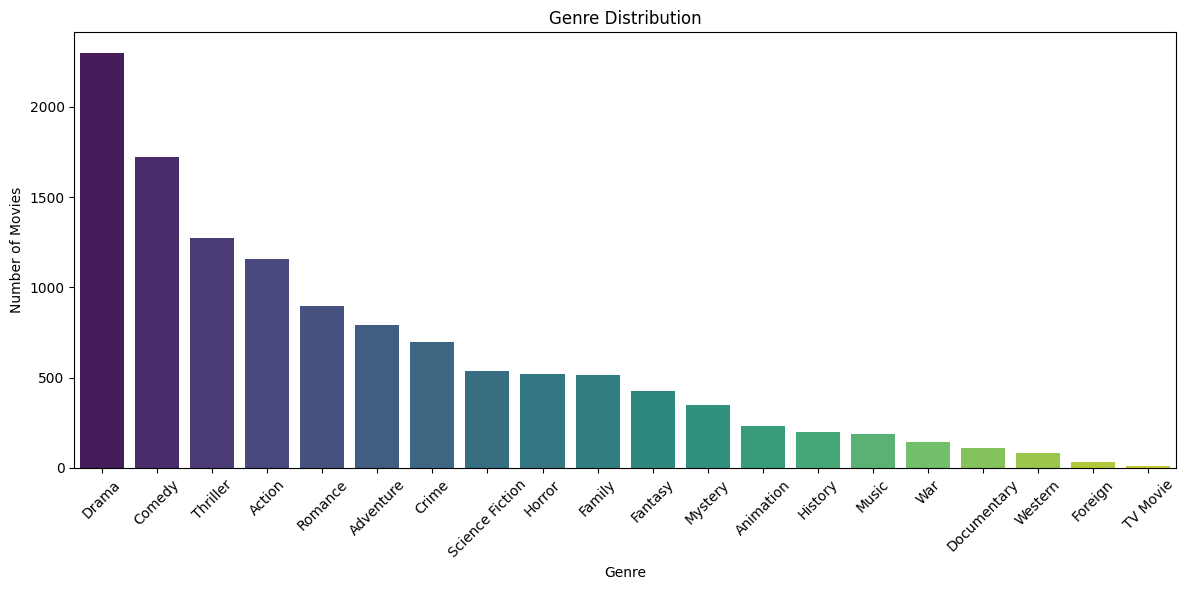

In [13]:
genre_counts = final_df['genre_list'].explode().value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

In [14]:
# This turns genre lists into binary features
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(final_df['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

In [15]:
# We scale vote_average and popularity to range [0, 1]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(final_df[['vote_average', 'popularity']])
scaled_df = pd.DataFrame(scaled_features, columns=['vote_average', 'popularity'])

In [16]:
#Combine all features into one matrix
final_features = pd.concat([genre_df, scaled_df], axis=1)

### 📊 Cluster Distribution - Bar Plot

After assigning cluster labels using KMeans with the optimal number of clusters (k=10), we wanted to see how many movies were grouped into each cluster. The bar plot below shows the count of movies in each cluster. This helps us understand if any clusters are too small or overly large.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4108\2877495633.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=final_df['cluster'], palette='coolwarm')


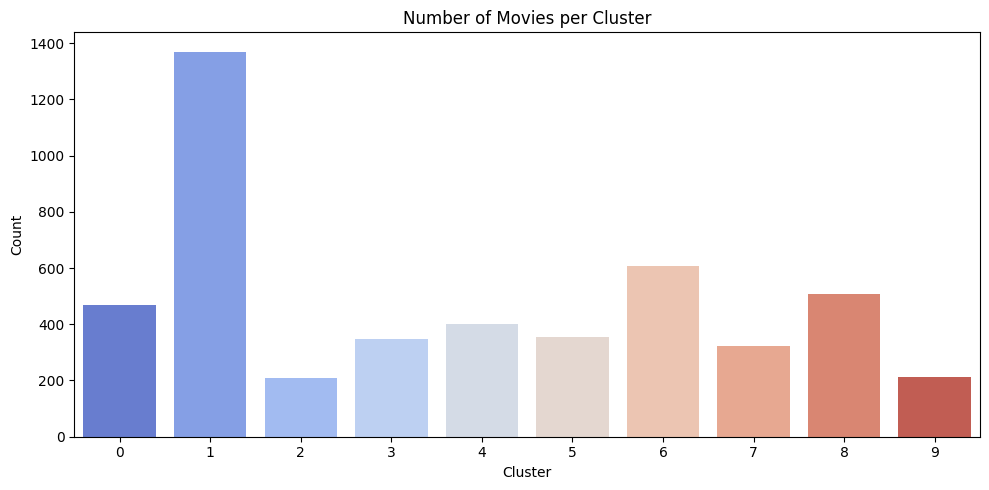

In [17]:
# Fit KMeans using chosen k (replace with optimal k from elbow plot)
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_df['cluster'] = kmeans.fit_predict(final_features)

# Plot how many movies per cluster
plt.figure(figsize=(10, 5))
sns.countplot(x=final_df['cluster'], palette='coolwarm')
plt.title('Number of Movies per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 🎯 Visualizing Clusters in 2D - Scatter Plot using PCA

To better understand how the clusters are spread in feature space, we reduced the features down to two dimensions using PCA (Principal Component Analysis). This scatter plot gives a more intuitive view of how movies are grouped together based on their similarities.

Each dot represents a movie, and colors indicate the cluster it belongs to.

1. X-axis: Principal Component 1

2. Y-axis: Principal Component 2

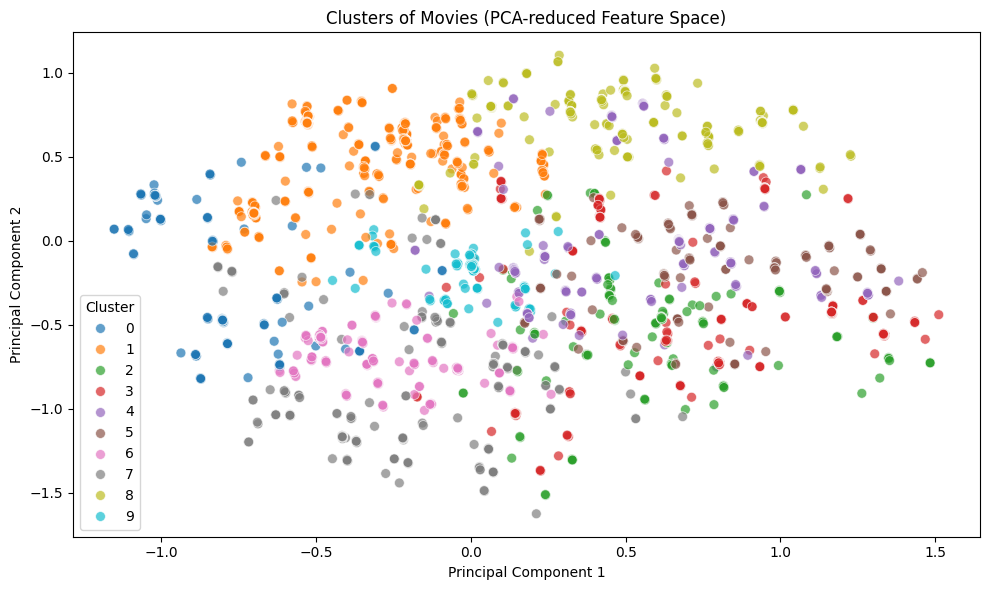

In [18]:
from sklearn.decomposition import PCA

# Reduce feature dimensions to 2 for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(final_features)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
pca_df['cluster'] = final_df['cluster']

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=50, alpha=0.7)
plt.title('Clusters of Movies (PCA-reduced Feature Space)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


In [19]:
#Define recommendation function
def recommend_movies(movie_title, n=5):
    """
    Recommend similar movies based on genre, popularity, and rating using clustering.
    
    Parameters:
        movie_title (str): Title of the movie to base recommendations on.
        n (int): Number of similar movies to return.
        
    Returns:
        pd.DataFrame: Top N recommended movies in the same cluster.
    """
    # Lowercase comparison for robust matching
    target = final_df[final_df['title'].str.lower() == movie_title.lower()]
    
    if target.empty:
        return f" Movie titled '{movie_title}' not found in dataset."
    
    # Get the cluster of the target movie
    cluster_id = target['cluster'].values[0]
    
    # Get all movies from the same cluster
    similar_movies = final_df[(final_df['cluster'] == cluster_id) & 
                            (final_df['title'].str.lower() != movie_title.lower())]
    
    # Return top N based on vote_average and popularity
    return similar_movies[['title', 'vote_average', 'popularity']].sort_values(
        by=['vote_average', 'popularity'], ascending=False).head(n)


# Example usage:

print(" Recommended movies similar to 'Avatar':")
print(recommend_movies("Spectre", n=5))

 Recommended movies similar to 'Avatar':
                        title  vote_average  popularity
1990  The Empire Strikes Back           8.2   78.517830
96                  Inception           8.1  167.583710
2912                Star Wars           8.1  126.393695
94    Guardians of the Galaxy           7.9  481.098624
274                 Gladiator           7.9   95.301296
